# DISCHARGE FORECASTING WITH PYCARET

Author: Tobias Siegfried, hydrosolutions GmbH
Source inspiration: https://pycaret.gitbook.io/docs/learn-pycaret/official-blog/time-series-101-for-beginners

This tutorial is a quick introduction to time series forecasting with pycaret. It is intended for beginners who are new to time series forecasting and pycaret. It uses a tailored regression approach as explained in the above-linked tutorial.

## Change Log
- 2023-04-20: Initial version
- 2023-04-23: Upgraded packages.
- 2023-04-23: New MBP environment pycaret_310 (works)
- 2023-05-25: Starting to add more features to the model. More precisely, we now have SCF for individual elevation bands in the catchment (see also https://hydrosolutions.users.earthengine.app/view/centralasia-snowcover-eb for the GEE app with which these data were produced)
- 2023-05-25: new branch scf_eb which is now the development branch for the model with SCF for individual elevation bands.

# PACKAGES & SETTINGS

## Packages

In [1]:
import numpy as np
import pandas as pd
from   fastai.tabular.core import add_datepart # adds time-based features to a dataframe
import plotly.express as px
#from pycaret.datasets import get_data

## Settings

In [2]:
global_fig_settings = {
    "renderer": "notebook",
    #"renderer": "png",
    "width": 1000,
    "height": 600,
    "template": "simple_white"
}

# 1 DATA

## 1.1 Load Data

Simply load the csv-data from the repository.

### 1.1.1 Inflow Toktogul Data

In [3]:
file_path = "./q_16936_xreg_wide.csv"
q_16936_xreg = pd.read_csv(file_path, parse_dates=True)
q_16936_xreg = q_16936_xreg[['date', 'q_16936', 'scf_16059', 'index_NAO', 'index_PDO']]
q_16936_xreg.rename(columns={'scf_16059':'scf', 'q_16936':'q'}, inplace=True) # just making notation easier
q_16936_xreg.head()

,date,q,scf,index_NAO,index_PDO
0,2001-01-31,173.0,1.057488,0.25,0.60
1,2001-02-28,169.0,1.072396,0.45,0.29
2,2001-03-31,202.0,0.861495,-1.26,0.45
3,2001-04-30,329.0,0.462854,0.00,-0.31
4,2001-05-31,761.0,-0.222963,-0.02,-0.30


In [4]:
# Create a copy of q_16936_xreg_wide containing only the index and the q_16936 column for later use.
q_obs = q_16936_xreg[['date', 'q']]
q_obs = q_obs.assign(desc = "observed") # remember this one for adding new column with constant value to existing dataframe.
q_obs.head()

,date,q,desc
0,2001-01-31,173.0,observed
1,2001-02-28,169.0,observed
2,2001-03-31,202.0,observed
3,2001-04-30,329.0,observed
4,2001-05-31,761.0,observed


Next, we define a function that transforms (log1p) and zscores discharge data. Also, define and inverse function to transforms back. Note, the function has been tested with the data from the repository. All seems to work fine.

In [5]:
def transform_and_zscore(df, columns):
    # Create an empty dictionary to store mean and std for each column
    mean_std_dict = {}
    
    for col in columns:
        # Apply log1p transformation
        df[col] = np.log1p(df[col])
        
        # Calculate mean and std of the transformed column
        mean = df[col].mean()
        std = df[col].std()
        
        # Store mean and std in the dictionary
        mean_std_dict[col] = {'mean': mean, 'std': std}
        
        # Compute z-scores
        df[col] = (df[col] - mean) / std
        
    return df, mean_std_dict

def inverse_transform_and_zscore(df, columns, mean_std_dict):
    for col in columns:
        # Retrieve the original mean and std from the mean_std_dict
        mean = mean_std_dict[col]['mean']
        std = mean_std_dict[col]['std']
        
        # Apply the inverse z-score transformation
        df[col] = df[col] * std + mean
        
        # Apply the inverse log1p transformation
        df[col] = np.expm1(df[col])
        
    return df

Checking the new function.

In [6]:
# check res
[q_16936_xreg,transform_dict] = transform_and_zscore(q_16936_xreg, ['q'])
q_16936_xreg.head()

,date,q,scf,index_NAO,index_PDO
0,2001-01-31,-1.171487,1.057488,0.25,0.60
1,2001-02-28,-1.209102,1.072396,0.45,0.29
2,2001-03-31,-0.922167,0.861495,-1.26,0.45
3,2001-04-30,-0.136305,0.462854,0.00,-0.31
4,2001-05-31,1.217204,-0.222963,-0.02,-0.30


In [7]:
# check dict
transform_dict    

{'q': {'mean': 5.88336785841461, 'std': 0.618284987235039}}

In [8]:
# check inverse
inverse_transform_and_zscore(q_16936_xreg, ['q'], transform_dict)

,date,q,scf,index_NAO,index_PDO
0,2001-01-31,173.0,1.057488,0.25,0.60
1,2001-02-28,169.0,1.072396,0.45,0.29
2,2001-03-31,202.0,0.861495,-1.26,0.45
3,2001-04-30,329.0,0.462854,0.00,-0.31
4,2001-05-31,761.0,-0.222963,-0.02,-0.30
...,...,...,...,...,...
259,2022-08-31,556.0,-1.802944,1.47,-1.92
260,2022-09-30,356.0,-1.479974,-1.61,-1.55
261,2022-10-31,240.0,0.175082,-0.72,-1.46
262,2022-11-30,235.0,0.841569,0.69,-1.90


Note above that the inverse function edited the data in place. So let's make a copy of the data before we apply the transformation function.

In [9]:
q_16936_xreg_zs = q_16936_xreg.copy()
transform_and_zscore(q_16936_xreg_zs, ['q'])
q_16936_xreg_zs.head()

,date,q,scf,index_NAO,index_PDO
0,2001-01-31,-1.171487,1.057488,0.25,0.60
1,2001-02-28,-1.209102,1.072396,0.45,0.29
2,2001-03-31,-0.922167,0.861495,-1.26,0.45
3,2001-04-30,-0.136305,0.462854,0.00,-0.31
4,2001-05-31,1.217204,-0.222963,-0.02,-0.30


### 1.1.2 Elevation Band Snow Cover Fraction Data

Silvan was kind enough to produce a special version of the SnowMapper App for us. It produces snow cover fraction (SCF) data for individual elevation bands in the catchment. The data is stored in a Google Earth Engine asset. We can access it via the GEE API and then load it here for inclusion in the forecasting model(s). The App is available at https://hydrosolutions.users.earthengine.app/view/centralasia-snowcover-eb  

In [10]:
# load data from csv file
scf_eb = pd.read_csv('./scf_eb_2000_2022.csv')
# delete the first and last columns of the scf_eb data frame
scf_eb.drop(scf_eb.columns[[0, -1]], axis=1, inplace=True)
scf_eb.head()
scf_eb_names = scf_eb.columns.to_list()
scf_eb_names = [scf_eb_names[-1]] + scf_eb_names[:-1]
scf_eb = scf_eb[scf_eb_names]
scf_eb.head()
# convert first column to datetime
scf_eb['Year-Month'] = pd.to_datetime(scf_eb['Year-Month'])
scf_eb.head()
# select columns of interest containing the 'Year-Month' column and all columns that contain the string 'Inflow Toktogul'
scf_eb = scf_eb.loc[:, scf_eb.columns.str.contains('Year-Month|Inflow Toktogul')]
# sort by date
scf_eb = scf_eb.sort_values(by='Year-Month')
scf_eb.head()   

,Year-Month,16936_01_Inflow Toktogul,16936_02_Inflow Toktogul,16936_03_Inflow Toktogul,16936_04_Inflow Toktogul,16936_05_Inflow Toktogul,16936_06_Inflow Toktogul,16936_07_Inflow Toktogul,16936_08_Inflow Toktogul,16936_09_Inflow Toktogul,16936_10_Inflow Toktogul
251,2001-01-01,60.048739,59.185281,61.155831,64.667218,64.991571,68.060968,69.305565,68.389142,67.969711,67.022177
184,2001-02-01,63.716917,63.597525,63.069116,66.033085,63.461071,69.499457,67.947831,69.089212,68.802689,67.627090
218,2001-03-01,19.515484,26.694688,34.137567,50.309419,56.367829,66.316129,65.212477,63.862333,64.962529,65.677419
126,2001-04-01,0.199333,3.435333,6.330291,16.462333,29.961741,43.222920,50.340924,51.541809,58.117304,60.990529
0,2001-05-01,0.051290,0.016774,0.093516,0.296774,2.531290,11.781461,15.849677,21.923428,36.829586,53.370645


## 1.2 Visualize Data

First, we plot the data just loaded to get a first impression of it. Note that we focus only on snow cover fraction for the moment in upstream Naryn catchment as we expect this to be the most important external regressor (driver) for the target variable.

In [13]:
fig = px.line(q_16936_xreg_zs,
              x="date", 
              y=["q","scf","index_NAO","index_PDO"], 
              title="Inflow Toktogul (zscored) and Snow Cover Fraction (upstream of Toktogul above gauge 16059))",
              template="simple_white")
fig.show()

Now, we can plot the snow cover fraction data for the elevation bands in the upstream Naryn catchment. We will use this data as an external regressor (driver) for the discharge forecasting model.

In [14]:
# plot scf_eb data using time series plot
fig = px.line(scf_eb,
                x="Year-Month",
                y = scf_eb.columns[1:],
                title="SCF Inflow  Toktogul",
                template="simple_white")
fig.show()

## EDA

Here, I tried to make chatGPT rewrite the R function plot_seasonal_diagnostics. It does not work so far and needs more love.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

def plot_seasonal_diagnostics(data, date_var, value, facet_vars=None, feature_set="auto",
                              geom="boxplot", geom_color="#2c3e50", geom_outlier_color="#2c3e50",
                              title="Seasonal Diagnostics", x_lab="", y_lab="",
                              interactive=False):

    def get_seasonal_auto_features(date_series):
        # Implement this function based on the R version to automatically select features
        pass

    if facet_vars is None:
        facet_vars = []

    if not isinstance(data, pd.DataFrame):
        raise ValueError("data is not a DataFrame. Please supply a pandas DataFrame.")

    if date_var not in data.columns:
        raise ValueError("date_var is missing. Please supply a date or date-time column.")

    if value not in data.columns:
        raise ValueError("value is missing. Please supply a numeric column.")

    if feature_set == "auto":
        feature_set = get_seasonal_auto_features(data[date_var])

    # Create a copy of the data for processing
    data_formatted = data.copy()

    # Process facet_vars
    for facet in facet_vars:
        if facet not in data_formatted.columns:
            raise ValueError(f"{facet} not found in data columns.")

    # Implement the data processing steps based on the R version
    # This includes the creation of the tk_seasonal_diagnostics function

    # Create the plot
    if interactive:
        fig = px.box(data_formatted, x=".group_value", y=value, color=facet_vars[0] if facet_vars else None,
                     facet_col=".group", facet_col_wrap=len(facet_vars) if facet_vars else 1)
        fig.update_traces(marker=dict(outliercolor=geom_outlier_color))
        fig.update_layout(title=title, xaxis_title=x_lab, yaxis_title=y_lab)
        return fig
    else:
        g = sns.FacetGrid(data_formatted, col=".group", col_wrap=len(facet_vars) if facet_vars else 1)
        if geom == "boxplot":
            g.map_dataframe(sns.boxplot, x=".group_value", y=value, color=geom_color)
        elif geom == "violin":
            g.map_dataframe(sns.violinplot, x=".group_value", y=value, color=geom_color)
        else:
            raise ValueError("geom should be either 'boxplot' or 'violin'")

        g.set_axis_labels(x_lab, y_lab)
        g.fig.suptitle(title)
        plt.tight_layout()
        plt.show()


In [38]:
plot_seasonal_diagnostics(data=q_16936_xreg_zs, date_var="date", value="q", feature_set="auto")

KeyError: '.group'

# 2 PREPARE DATA

We have a nicely prepared dataset for Naryn inflow to Toktogul. Now, we need to prepare it for training and testing.

In [10]:
prep_data = q_16936_xreg_zs.copy()
prep_data.head()

,date,q,scf,index_NAO,index_PDO
0,2001-01-31,-1.171487,1.057488,0.25,0.60
1,2001-02-28,-1.209102,1.072396,0.45,0.29
2,2001-03-31,-0.922167,0.861495,-1.26,0.45
3,2001-04-30,-0.136305,0.462854,0.00,-0.31
4,2001-05-31,1.217204,-0.222963,-0.02,-0.30


In [11]:
prep_data.tail()

,date,q,scf,index_NAO,index_PDO
259,2022-08-31,0.710348,-1.802944,1.47,-1.92
260,2022-09-30,-0.009109,-1.479974,-1.61,-1.55
261,2022-10-31,-0.644639,0.175082,-0.72,-1.46
262,2022-11-30,-0.678548,0.841569,0.69,-1.90
263,2022-12-31,-0.792095,1.071463,-0.15,-1.52


## 2.1 Account for Acquisition Delays

We need to account for the acquisition delays of the satellite data. This is done by shifting the external regressors by the acquisition delay which is assumed to be one month here.

In [12]:
# Add lag 1 version of the scf variable to the q_16936_xreg_wide dataframe.
prep_data['scf_lag1'] = prep_data['scf'].shift(1)
prep_data.head()

,date,q,scf,index_NAO,index_PDO,scf_lag1
0,2001-01-31,-1.171487,1.057488,0.25,0.60,NaN
1,2001-02-28,-1.209102,1.072396,0.45,0.29,1.057488
2,2001-03-31,-0.922167,0.861495,-1.26,0.45,1.072396
3,2001-04-30,-0.136305,0.462854,0.00,-0.31,0.861495
4,2001-05-31,1.217204,-0.222963,-0.02,-0.30,0.462854


## 2.2 Diff Data

 Take the first difference of q and scf. This is then the final data we will use for training and testing. 

In [13]:
prep_data['d_q'] = prep_data['q'].diff()
prep_data['d_scf_lag1'] = prep_data['scf_lag1'].diff()
prep_data['d2_scf_lag1'] = prep_data['d_scf_lag1'].diff(periods=2)
prep_data['d3_scf_lag1'] = prep_data['d_scf_lag1'].diff(periods=3)
prep_data.head()

,date,q,scf,index_NAO,index_PDO,scf_lag1,d_q,d_scf_lag1,d2_scf_lag1,d3_scf_lag1
0,2001-01-31,-1.171487,1.057488,0.25,0.60,NaN,NaN,NaN,NaN,NaN
1,2001-02-28,-1.209102,1.072396,0.45,0.29,1.057488,-0.037615,NaN,NaN,NaN
2,2001-03-31,-0.922167,0.861495,-1.26,0.45,1.072396,0.286935,0.014908,NaN,NaN
3,2001-04-30,-0.136305,0.462854,0.00,-0.31,0.861495,0.785862,-0.210901,NaN,NaN
4,2001-05-31,1.217204,-0.222963,-0.02,-0.30,0.462854,1.353508,-0.398641,-0.413548,NaN


## 2.3 Add Time-Based Features

We add time-based features to the data. This is done by using the `add_datepart` function from fastai.

In [14]:
# Use the fastai add_datepart function to add time-based features to the dataframe.
#prep_data.add_datepart('date')
add_datepart(prep_data, 'date', drop=False)
prep_data.head()

,date,q,scf,index_NAO,index_PDO,scf_lag1,d_q,d_scf_lag1,d2_scf_lag1,d3_scf_lag1,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2001-01-31,-1.171487,1.057488,0.25,0.60,NaN,NaN,NaN,NaN,NaN,...,31,2,31,True,False,False,False,False,False,980899200.0
1,2001-02-28,-1.209102,1.072396,0.45,0.29,1.057488,-0.037615,NaN,NaN,NaN,...,28,2,59,True,False,False,False,False,False,983318400.0
2,2001-03-31,-0.922167,0.861495,-1.26,0.45,1.072396,0.286935,0.014908,NaN,NaN,...,31,5,90,True,False,True,False,False,False,985996800.0
3,2001-04-30,-0.136305,0.462854,0.00,-0.31,0.861495,0.785862,-0.210901,NaN,NaN,...,30,0,120,True,False,False,False,False,False,988588800.0
4,2001-05-31,1.217204,-0.222963,-0.02,-0.30,0.462854,1.353508,-0.398641,-0.413548,NaN,...,31,3,151,True,False,False,False,False,False,991267200.0


Finally, we add a series of numbers to the dataframe and call the resulting column Series.

In [15]:
# Add a series of numbers to the dataframe to use as a unique identifier for each row. Call the column Series.
prep_data['Series'] = np.arange(len(prep_data)) + 1
prep_data.head()

,date,q,scf,index_NAO,index_PDO,scf_lag1,d_q,d_scf_lag1,d2_scf_lag1,d3_scf_lag1,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,Series
0,2001-01-31,-1.171487,1.057488,0.25,0.60,NaN,NaN,NaN,NaN,NaN,...,2,31,True,False,False,False,False,False,980899200.0,1
1,2001-02-28,-1.209102,1.072396,0.45,0.29,1.057488,-0.037615,NaN,NaN,NaN,...,2,59,True,False,False,False,False,False,983318400.0,2
2,2001-03-31,-0.922167,0.861495,-1.26,0.45,1.072396,0.286935,0.014908,NaN,NaN,...,5,90,True,False,True,False,False,False,985996800.0,3
3,2001-04-30,-0.136305,0.462854,0.00,-0.31,0.861495,0.785862,-0.210901,NaN,NaN,...,0,120,True,False,False,False,False,False,988588800.0,4
4,2001-05-31,1.217204,-0.222963,-0.02,-0.30,0.462854,1.353508,-0.398641,-0.413548,NaN,...,3,151,True,False,False,False,False,False,991267200.0,5


We have now all the necessary features to train a model. But before that, we remove the unnecessary columns. and create the prep_df dataframe. We create one version with the snow cover fraction and one without. Like this, we can conduct two different experiments and test which one performs better to get an idea of the importance of the external regressor (value of information).

In [16]:
prep_df = prep_data[['date', 'Series', 'q', 'd_q', 'scf_lag1', 'd_scf_lag1', 'd2_scf_lag1', 'd3_scf_lag1', 'Year', 'Month']].copy()
prep_df.tail()

,date,Series,q,d_q,scf_lag1,d_scf_lag1,d2_scf_lag1,d3_scf_lag1,Year,Month
259,2022-08-31,260,0.710348,-0.613625,-1.752682,-1.042841,-0.268696,-0.644567,2022,8
260,2022-09-30,261,-0.009109,-0.719457,-1.802944,-0.050262,0.392926,0.723883,2022,9
261,2022-10-31,262,-0.644639,-0.635530,-1.479974,0.322970,1.365811,0.766157,2022,10
262,2022-11-30,263,-0.678548,-0.033909,0.175082,1.655056,1.705318,2.697897,2022,11
263,2022-12-31,264,-0.792095,-0.113547,0.841569,0.666487,0.343517,0.716749,2022,12


In [17]:
# Plot the prep_df dataframe.
fig = px.line(prep_df, x="Series", y=["q", "scf_lag1","d_q","d_scf_lag1","d2_scf_lag1","d3_scf_lag1"], 
              template = 'plotly_dark')
fig.show()

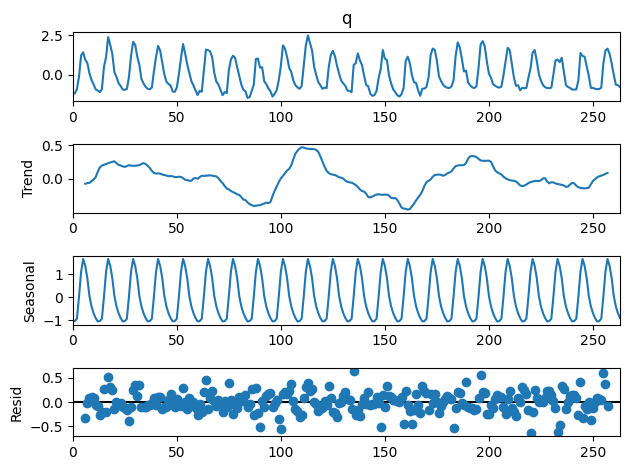

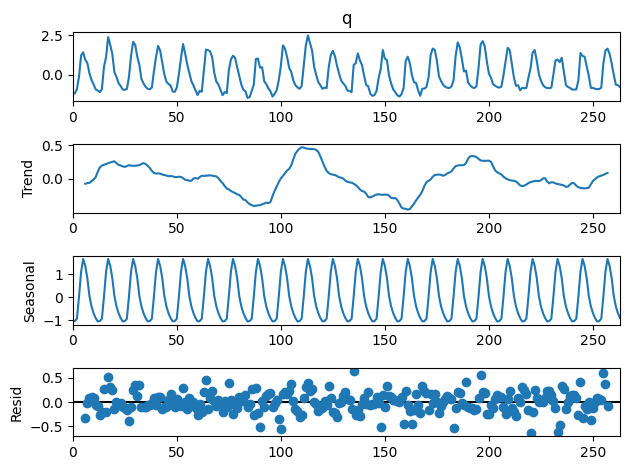

In [18]:
# make a seasonal decomposition of the prep_df dataframe and the column q_zs therein.
from statsmodels.tsa.seasonal import seasonal_decompose 
seasonal_decompose(prep_df['q'], model='additive', period=12).plot()

## 2.4 Add Long-Lag Features

We want to add rolling long lag features with the rolling mean over 12, 6, and 3 months. 

In [19]:
prep_df

,date,Series,q,d_q,scf_lag1,d_scf_lag1,d2_scf_lag1,d3_scf_lag1,Year,Month
0,2001-01-31,1,-1.171487,NaN,NaN,NaN,NaN,NaN,2001,1
1,2001-02-28,2,-1.209102,-0.037615,1.057488,NaN,NaN,NaN,2001,2
2,2001-03-31,3,-0.922167,0.286935,1.072396,0.014908,NaN,NaN,2001,3
3,2001-04-30,4,-0.136305,0.785862,0.861495,-0.210901,NaN,NaN,2001,4
4,2001-05-31,5,1.217204,1.353508,0.462854,-0.398641,-0.413548,NaN,2001,5
...,...,...,...,...,...,...,...,...,...,...
259,2022-08-31,260,0.710348,-0.613625,-1.752682,-1.042841,-0.268696,-0.644567,2022,8
260,2022-09-30,261,-0.009109,-0.719457,-1.802944,-0.050262,0.392926,0.723883,2022,9
261,2022-10-31,262,-0.644639,-0.635530,-1.479974,0.322970,1.365811,0.766157,2022,10
262,2022-11-30,263,-0.678548,-0.033909,0.175082,1.655056,1.705318,2.697897,2022,11


In [22]:
#prep_df

# Set 'date' column as the index
#prep_df.set_index('date', inplace=True)

# Calculate the rolling average over 12 months
#prep_df['roll_avg_12_lag12'] = prep_df['q_zs'].rolling(12).mean()
# Shift the rolling average by 12 months into the future
#prep_df['roll_avg_12_lag12_shift'] = prep_df['roll_avg_12_lag12'].shift(12)

#prep_df

# Reset the index if you want the 'date' column back
#prep_df.reset_index(inplace=True)
#prep_df.tail()

Extending to future frames

In [20]:
def create_future_df(prep_df, fh):
    # dates
    last_date = prep_df['date'].iloc[-1]
    future_dates = pd.date_range(start=last_date, periods=fh+1, freq='M')[1:]
    future_df = pd.DataFrame(columns=prep_df.columns)
    future_df['date'] = future_dates
    # year and month
    future_df['Year'] = future_df['date'].dt.year
    future_df['Month'] = future_df['date'].dt.month
    # Series
    last_series = prep_df['Series'].iloc[-1]
    future_series = np.arange(last_series+1, last_series+fh+1)
    future_df['Series'] = future_series
    #future_df.set_index('date', inplace=True)
    #future_df[prep_df.columns[1:]] = np.nan
    return future_df

future_df = create_future_df(prep_df, 12)
future_df.head(12)

,date,Series,q,d_q,scf_lag1,d_scf_lag1,d2_scf_lag1,d3_scf_lag1,Year,Month
0,2023-01-31,265,NaN,NaN,NaN,NaN,NaN,NaN,2023,1
1,2023-02-28,266,NaN,NaN,NaN,NaN,NaN,NaN,2023,2
2,2023-03-31,267,NaN,NaN,NaN,NaN,NaN,NaN,2023,3
3,2023-04-30,268,NaN,NaN,NaN,NaN,NaN,NaN,2023,4
4,2023-05-31,269,NaN,NaN,NaN,NaN,NaN,NaN,2023,5
5,2023-06-30,270,NaN,NaN,NaN,NaN,NaN,NaN,2023,6
6,2023-07-31,271,NaN,NaN,NaN,NaN,NaN,NaN,2023,7
7,2023-08-31,272,NaN,NaN,NaN,NaN,NaN,NaN,2023,8
8,2023-09-30,273,NaN,NaN,NaN,NaN,NaN,NaN,2023,9
9,2023-10-31,274,NaN,NaN,NaN,NaN,NaN,NaN,2023,10


Now, we can combine the prep_df and the future_df and then do the long lag features trick and, after that, split the data again.

In [21]:
def add_long_lag_features(prep_df, future_df, lag):
    result_df = pd.concat([prep_df, future_df])
    result_df['q_lag_'+str(lag)] = result_df['q'].shift(lag).rolling(lag).mean()
    lag_div_2 = int(lag/2)
    lag_div_4 = int(lag/4)
    result_df['q_lag_'+str(lag_div_2)] = result_df['q'].shift(lag).rolling(lag_div_2).mean()
    result_df['q_lag_'+str(lag_div_4)] = result_df['q'].shift(lag).rolling(lag_div_4).mean()
    return result_df

full_long_lag = add_long_lag_features(prep_df, future_df, 12)
px.line(full_long_lag, x="Series", y=["q", "q_lag_12", "q_lag_6", "q_lag_3"], template = 'plotly_dark')

This is now the prepared dataframe concatenated with the future dataframe. The resulting full_long_lag dataframe is the basis for the next section. We split it for training and testing the model in the regression experiments section below.

In [22]:
full_long_lag

,date,Series,q,d_q,scf_lag1,d_scf_lag1,d2_scf_lag1,d3_scf_lag1,Year,Month,q_lag_12,q_lag_6,q_lag_3
0,2001-01-31,1,-1.171487,NaN,NaN,NaN,NaN,NaN,2001,1,NaN,NaN,NaN
1,2001-02-28,2,-1.209102,-0.037615,1.057488,NaN,NaN,NaN,2001,2,NaN,NaN,NaN
2,2001-03-31,3,-0.922167,0.286935,1.072396,0.014908,NaN,NaN,2001,3,NaN,NaN,NaN
3,2001-04-30,4,-0.136305,0.785862,0.861495,-0.210901,NaN,NaN,2001,4,NaN,NaN,NaN
4,2001-05-31,5,1.217204,1.353508,0.462854,-0.398641,-0.413548,NaN,2001,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2023-08-31,272,NaN,NaN,NaN,NaN,NaN,NaN,2023,8,0.045312,0.848276,1.229841
8,2023-09-30,273,NaN,NaN,NaN,NaN,NaN,NaN,2023,9,0.051492,0.986227,0.675070
9,2023-10-31,274,NaN,NaN,NaN,NaN,NaN,NaN,2023,10,0.068773,0.762827,0.018866
10,2023-11-30,275,NaN,NaN,NaN,NaN,NaN,NaN,2023,11,0.083227,0.392871,-0.444099


Adding back the original q data and then splitting to prepared and future data.

In [23]:
full_long_lag_q_orig = full_long_lag.copy()
inverse_transform_and_zscore(full_long_lag_q_orig,['q'],transform_dict)

data_prep = full_long_lag[full_long_lag['date'] < '2023-01-01']
data_fut = full_long_lag[full_long_lag['date'] >= '2023-01-01']

data_prep_q_orig = full_long_lag_q_orig[full_long_lag_q_orig['date'] < '2023-01-01']
data_fut_q_orig = full_long_lag_q_orig[full_long_lag_q_orig['date'] >= '2023-01-01']

In [24]:
data_prep

,date,Series,q,d_q,scf_lag1,d_scf_lag1,d2_scf_lag1,d3_scf_lag1,Year,Month,q_lag_12,q_lag_6,q_lag_3
0,2001-01-31,1,-1.171487,NaN,NaN,NaN,NaN,NaN,2001,1,NaN,NaN,NaN
1,2001-02-28,2,-1.209102,-0.037615,1.057488,NaN,NaN,NaN,2001,2,NaN,NaN,NaN
2,2001-03-31,3,-0.922167,0.286935,1.072396,0.014908,NaN,NaN,2001,3,NaN,NaN,NaN
3,2001-04-30,4,-0.136305,0.785862,0.861495,-0.210901,NaN,NaN,2001,4,NaN,NaN,NaN
4,2001-05-31,5,1.217204,1.353508,0.462854,-0.398641,-0.413548,NaN,2001,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2022-08-31,260,0.710348,-0.613625,-1.752682,-1.042841,-0.268696,-0.644567,2022,8,-0.087788,0.490495,0.957552
260,2022-09-30,261,-0.009109,-0.719457,-1.802944,-0.050262,0.392926,0.723883,2022,9,-0.113281,0.634325,0.532618
261,2022-10-31,262,-0.644639,-0.635530,-1.479974,0.322970,1.365811,0.766157,2022,10,-0.129438,0.552675,-0.131026
262,2022-11-30,263,-0.678548,-0.033909,0.175082,1.655056,1.705318,2.697897,2022,11,-0.134431,0.180896,-0.595760


In [25]:
data_prep_q_orig

,date,Series,q,d_q,scf_lag1,d_scf_lag1,d2_scf_lag1,d3_scf_lag1,Year,Month,q_lag_12,q_lag_6,q_lag_3
0,2001-01-31,1,173.0,NaN,NaN,NaN,NaN,NaN,2001,1,NaN,NaN,NaN
1,2001-02-28,2,169.0,-0.037615,1.057488,NaN,NaN,NaN,2001,2,NaN,NaN,NaN
2,2001-03-31,3,202.0,0.286935,1.072396,0.014908,NaN,NaN,2001,3,NaN,NaN,NaN
3,2001-04-30,4,329.0,0.785862,0.861495,-0.210901,NaN,NaN,2001,4,NaN,NaN,NaN
4,2001-05-31,5,761.0,1.353508,0.462854,-0.398641,-0.413548,NaN,2001,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2022-08-31,260,556.0,-0.613625,-1.752682,-1.042841,-0.268696,-0.644567,2022,8,-0.087788,0.490495,0.957552
260,2022-09-30,261,356.0,-0.719457,-1.802944,-0.050262,0.392926,0.723883,2022,9,-0.113281,0.634325,0.532618
261,2022-10-31,262,240.0,-0.635530,-1.479974,0.322970,1.365811,0.766157,2022,10,-0.129438,0.552675,-0.131026
262,2022-11-30,263,235.0,-0.033909,0.175082,1.655056,1.705318,2.697897,2022,11,-0.134431,0.180896,-0.595760


# 3 REGRESSION EXPERIMENTS

In this section, we create two forecasting experiments. One with the snow cover fraction as external regressor and one without. We also tets the value added of including the Series column in forecasting.

## 3.1 Regression Experiment 1: SCF and Year/Month

### 3.1.1 Data Preparation

No need for further preparation steps. Here is the training data.

In [26]:
data_prep

,date,Series,q,d_q,scf_lag1,d_scf_lag1,d2_scf_lag1,d3_scf_lag1,Year,Month,q_lag_12,q_lag_6,q_lag_3
0,2001-01-31,1,-1.171487,NaN,NaN,NaN,NaN,NaN,2001,1,NaN,NaN,NaN
1,2001-02-28,2,-1.209102,-0.037615,1.057488,NaN,NaN,NaN,2001,2,NaN,NaN,NaN
2,2001-03-31,3,-0.922167,0.286935,1.072396,0.014908,NaN,NaN,2001,3,NaN,NaN,NaN
3,2001-04-30,4,-0.136305,0.785862,0.861495,-0.210901,NaN,NaN,2001,4,NaN,NaN,NaN
4,2001-05-31,5,1.217204,1.353508,0.462854,-0.398641,-0.413548,NaN,2001,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2022-08-31,260,0.710348,-0.613625,-1.752682,-1.042841,-0.268696,-0.644567,2022,8,-0.087788,0.490495,0.957552
260,2022-09-30,261,-0.009109,-0.719457,-1.802944,-0.050262,0.392926,0.723883,2022,9,-0.113281,0.634325,0.532618
261,2022-10-31,262,-0.644639,-0.635530,-1.479974,0.322970,1.365811,0.766157,2022,10,-0.129438,0.552675,-0.131026
262,2022-11-30,263,-0.678548,-0.033909,0.175082,1.655056,1.705318,2.697897,2022,11,-0.134431,0.180896,-0.595760


And here the test data.

In [27]:
data_fut

,date,Series,q,d_q,scf_lag1,d_scf_lag1,d2_scf_lag1,d3_scf_lag1,Year,Month,q_lag_12,q_lag_6,q_lag_3
0,2023-01-31,265,NaN,NaN,NaN,NaN,NaN,NaN,2023,1,-0.136939,-0.513591,-0.896156
1,2023-02-28,266,NaN,NaN,NaN,NaN,NaN,NaN,2023,2,-0.133578,-0.757652,-0.919544
2,2023-03-31,267,NaN,NaN,NaN,NaN,NaN,NaN,2023,3,-0.124459,-0.883243,-0.896379
3,2023-04-30,268,NaN,NaN,NaN,NaN,NaN,NaN,2023,4,-0.036303,-0.625282,-0.354407
4,2023-05-31,269,NaN,NaN,NaN,NaN,NaN,NaN,2023,5,-0.022760,-0.226417,0.466710
5,2023-06-30,270,NaN,NaN,NaN,NaN,NaN,NaN,2023,6,0.015879,0.200502,1.297384
6,2023-07-31,271,NaN,NaN,NaN,NaN,NaN,NaN,2023,7,0.031299,0.576190,1.506787
7,2023-08-31,272,NaN,NaN,NaN,NaN,NaN,NaN,2023,8,0.045312,0.848276,1.229841
8,2023-09-30,273,NaN,NaN,NaN,NaN,NaN,NaN,2023,9,0.051492,0.986227,0.675070
9,2023-10-31,274,NaN,NaN,NaN,NaN,NaN,NaN,2023,10,0.068773,0.762827,0.018866


### 3.1.2 Baseline Experiment

Note: This is borrowed from the official pycaret documentation and can be found at https://nbviewer.org/github/pycaret/pycaret/blob/master/tutorials/Tutorial%20-%20Time%20Series%20Forecasting.ipynb.

The setup function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. setup() must called before executing any other function in pycaret. It takes two mandatory parameters: a pandas dataframe and the name of the target column. All other parameters are optional.

In [28]:
from pycaret.regression import RegressionExperiment
reg_exp_bl = RegressionExperiment()
reg_exp_bl.setup(data_prep, 
        target = "q", 
        data_split_shuffle = False, 
        fold_strategy = "timeseries",
        #numeric_features = ['Month'],
        categorical_features = ['Month'],
        #date_features = ['date'],
        ignore_features=['date','Series', 'q_lag_12', 'q_lag_6', 'q_lag_3', "scf_lag1", "Year", "d_q", 
                         "d_scf_lag1", "d2_scf_lag1", "d3_scf_lag1"],
        train_size=0.7272727272727273, # it just means we have 6 years of data for hold out testing
        transform_target = True,
        session_id = 123,
        log_experiment=True,
        experiment_name='reg_exp_bl')

,Description,Value
0,Session id,123
1,Target,q
2,Target type,Regression
3,Original data shape,"(264, 13)"
4,Transformed data shape,"(264, 13)"
5,Transformed train set shape,"(192, 13)"
6,Transformed test set shape,"(72, 13)"
7,Ignore features,11
8,Categorical features,1
9,Rows with missing values,8.7%


session_id is used for reproducibility. If None, a random integer is generated and returned at the end of the run. This can be used to reproduce the same results again. If an integer is passed, this pseudo-random number is distributed as a seed in all functions for later reproducibility. The fold_strategy parameter is used to define the type of cross-validation. The default value is None which is equivalent to 'None'. Other options are 'timeseries' and 'expanding window'. The 'timeseries' option is used to create a rolling forecast where the test set is always ahead of the train set.

`compare_models()` function compares all models in the model library and scores them using the Mean Squared Error (MSE) metric by default. It returns a score grid that shows Accuracy, AUC, Recall, Precision, F1, Kappa and MCC by fold (default = 10 Folds). The scoring grid that can be used for model selection. Metrics evaluated during CV can be accessed using the get_metrics function. Custom metrics can be added or removed using add_metric and remove_metric function.

In [29]:
reg_model_bl_best = reg_exp_bl.compare_models()

This function trains and evaluates the performance of all the estimators available in the model library using cross-validation. The output of this function is a scoring grid with average cross-validated scores. Metrics evaluated during CV can be accessed using the get_metrics function. Custom metrics can be added or removed using add_metric and remove_metric function. We can get the scoring grid as follows:

In [30]:
reg_exp_bl.pull(reg_model_bl_best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.2680,0.1115,0.3184,0.8864,0.1690,0.7703,0.013
br,Bayesian Ridge,0.2688,0.1131,0.3208,0.8845,0.1679,0.7969,0.008
lar,Least Angle Regression,0.2708,0.1140,0.3224,0.8834,0.1686,0.8064,0.008
lr,Linear Regression,0.2698,0.1139,0.3217,0.8834,0.1668,0.8005,0.164
catboost,CatBoost Regressor,0.2707,0.1139,0.3224,0.8834,0.1685,0.8062,0.053
xgboost,Extreme Gradient Boosting,0.2707,0.1139,0.3224,0.8834,0.1685,0.8064,0.011
et,Extra Trees Regressor,0.2708,0.1140,0.3224,0.8834,0.1686,0.8064,0.018
dt,Decision Tree Regressor,0.2708,0.1140,0.3224,0.8834,0.1686,0.8064,0.008
huber,Huber Regressor,0.2785,0.1178,0.3322,0.8788,0.1677,0.7942,0.008
rf,Random Forest Regressor,0.2776,0.1204,0.3344,0.8772,0.1749,0.7942,0.018


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

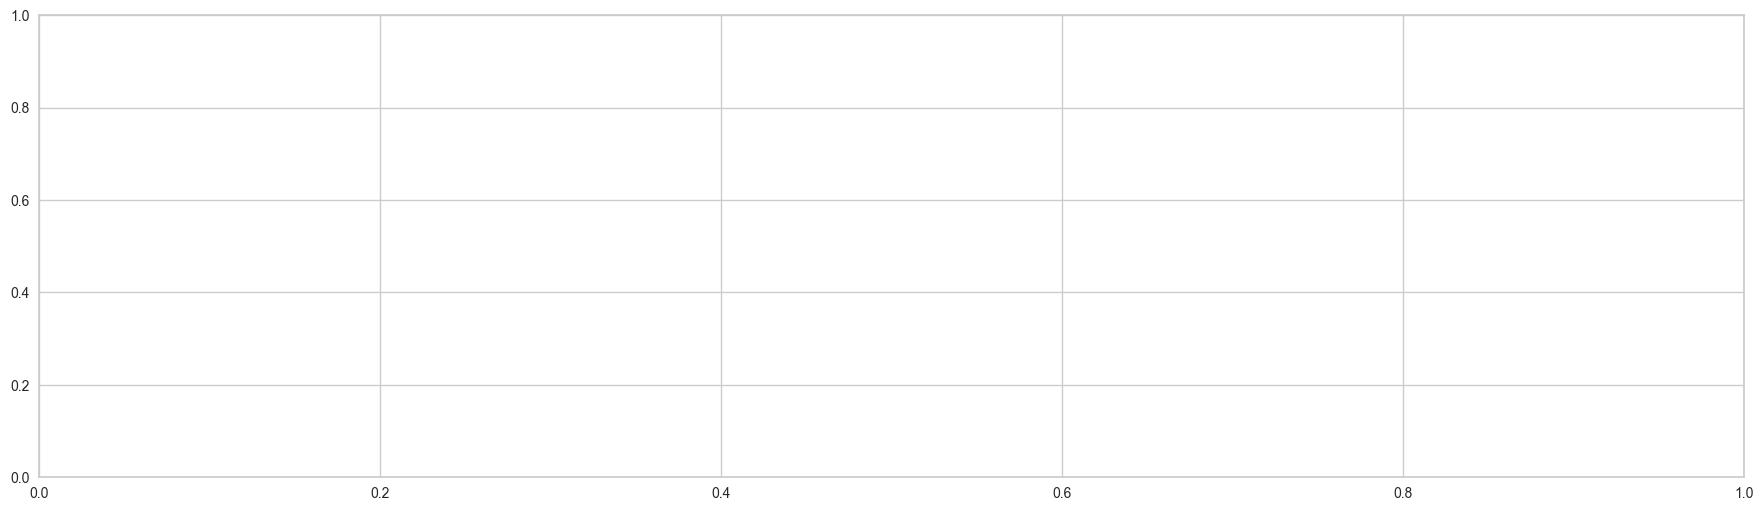

In [31]:
reg_exp_bl.evaluate_model(reg_model_bl_best)

According to the results, the best model is the `Gradient Boosting Regressor` regressor.

In [32]:
prediction_holdout = reg_exp_bl.predict_model(reg_model_bl_best) 
# This function predicts Label using a trained model. When data is None, it predicts label on the holdout set.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.2060,0.0817,0.2858,0.8950,0.1568,0.4908


We can use the `plot_model()` function to analyze the performance of a trained model on the test set.

To see the feature importance, we can use the `plot_model()` function with the parameter `plot = 'feature'`. 

Finally, forecast the model on the test set using the `predict_model()` function.

In [36]:
# TEST SET PREDICTIONS
# generate predictions on the original dataset
predictions = reg_exp_bl.predict_model(reg_model_bl_best)
predictions
# add a date column in the dataset
predictions['date'] = pd.date_range(start='2017-01-01', end = '2022-12-01', freq = 'MS')

# line plot**
px.line(predictions, x='date', y=["q", "prediction_label"], template = 'plotly_dark')

# add a vertical rectangle for test-set separation**
#fig.add_vrect(x0="2020-01-01", x1="2022-12-01", fillcolor="grey", opacity=0.25, line_width=0)
#fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.2060,0.0817,0.2858,0.8950,0.1568,0.4908


This is exactly the same thing as when we perform time series regression in R using the timetk package function.

In [39]:
# TEST SET PREDICTIONS Dataframe now with added predictions
predictions.head()

,Month,q,prediction_label,date
192,1,-0.821772,-1.105559,2017-01-01
193,2,-0.859652,-1.080263,2017-02-01
194,3,-0.755748,-0.945702,2017-03-01
195,4,0.400881,-0.056952,2017-04-01
196,5,1.925890,1.037516,2017-05-01


Back-transform the predictions to the original scale.

First, we create a function that copies dictionary keys to the prediction_label key. After that, we can compare actual with predicted values.

In [40]:
def copy_dict_entry(dictionary, existing_key, new_key):
    if existing_key in dictionary:
        dictionary[new_key] = dictionary[existing_key]
    else:
        return f"Error: '{existing_key}' not found in the dictionary."

    return dictionary

In [41]:
copy_dict_entry(transform_dict, 'q', 'prediction_label')
predictions_inversed = inverse_transform_and_zscore(predictions, ['q','prediction_label'], transform_dict)

In [42]:
px.line(predictions_inversed, x='date', y=["q", "prediction_label"], template = 'plotly_dark',
        title='Train Set Predictions Using Month Model', labels={'date':'Date', 'value':'q'})

In this experiment, we would need to generate the future frame now and then use the `predict_model` function to predict the future values.

Below, we repeat simple Experiment 1 in a compact form.

In [43]:
reg_exp_month = RegressionExperiment()
reg_exp_month.setup(data_prep, 
        target = "q", 
        data_split_shuffle = False, 
        fold_strategy = "timeseries",
        categorical_features = ['Month'],
        ignore_features=['date','Year','Series','scf_lag1','q_lag_12','q_lag_6','q_lag_3', 'd_q', 'd_scf_lag1',
                         'd2_scf_lag1', 'd3_scf_lag1'],
        train_size=0.7272727272727273, # it just means we have 6 years of data for hold out testing
        #date_features=['date'],
        transform_target = False,
        session_id = 123,
        log_experiment=True,
        experiment_name='reg_exp_month')

# COMPARE MODELS
reg_model_month_best = reg_exp_month.compare_models()
# TRAIN SET PREDICTIONS
predictions = reg_exp_month.predict_model(reg_model_month_best)
predictions['date'] = pd.date_range(start='2017-01-01', end = '2022-12-01', freq = 'MS')
predictions_inversed = inverse_transform_and_zscore(predictions, ['q','prediction_label'], transform_dict)
px.line(predictions_inversed, x='date', y=["q", "prediction_label"], template = 'plotly_dark', 
        title='Train and Test Set Predictions Using Month Model', labels={'date':'Date', 'value':'q'})

,Description,Value
0,Session id,123
1,Target,q
2,Target type,Regression
3,Original data shape,"(264, 13)"
4,Transformed data shape,"(264, 13)"
5,Transformed train set shape,"(192, 13)"
6,Transformed test set shape,"(72, 13)"
7,Ignore features,11
8,Categorical features,1
9,Rows with missing values,8.7%


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.2137,0.0806,0.2840,0.9093,0.1548,0.4581


And something to riddle on. If we tell pycaret that we have a date_feature and leave all else the same, we get a different result. Why is that?

,Description,Value
0,Session id,123
1,Target,q
2,Target type,Regression
3,Original data shape,"(264, 13)"
4,Transformed data shape,"(264, 4)"
5,Transformed train set shape,"(192, 4)"
6,Transformed test set shape,"(72, 4)"
7,Ignore features,11
8,Date features,1
9,Rows with missing values,8.7%


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,str,0.2172,0.0893,0.2988,0.8996,0.1630,0.6081


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

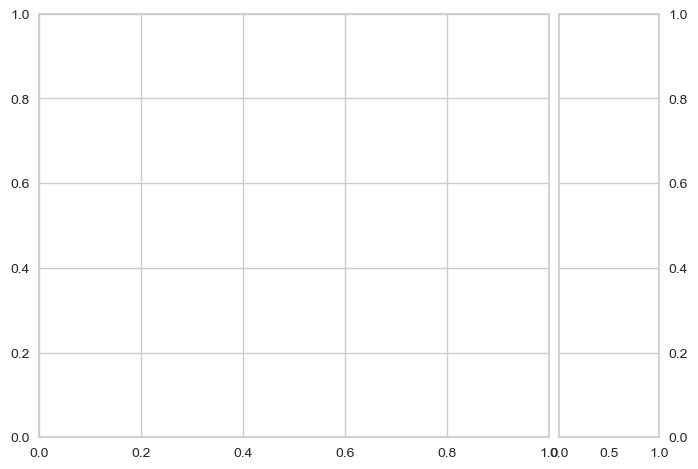

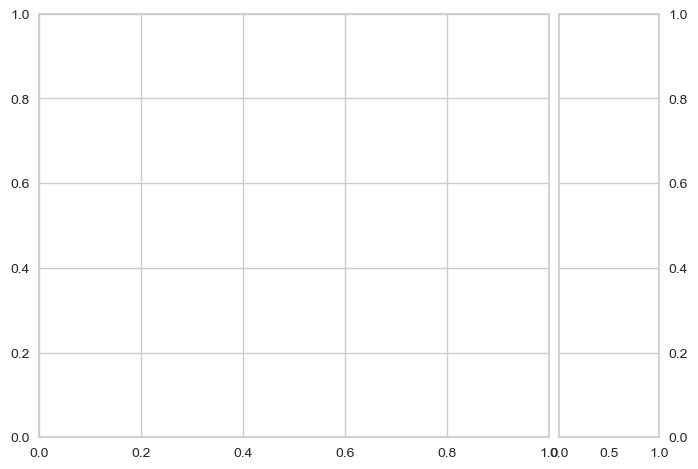

In [46]:
reg_exp_month = RegressionExperiment()
reg_exp_month.setup(data_prep, 
        target = "q", 
        data_split_shuffle = False, 
        fold_strategy = "timeseries",
        #numeric_features = ['Month'],
        ignore_features=['Month','Year','Series','scf_lag1','q_lag_12','q_lag_6','q_lag_3', 'd_q', 'd_scf_lag1',
                         'd2_scf_lag1', 'd3_scf_lag1'],
        date_features=['date'],
        train_size=0.7272727272727273,
        transform_target = False,
        session_id = 123,
        log_experiment=True,
        experiment_name='reg_exp_month_with_date')

# COMPARE MODELS
reg_model_month_best = reg_exp_month.compare_models()
# TRAIN SET PREDICTIONS
predictions = reg_exp_month.predict_model(reg_model_month_best)
predictions['date'] = pd.date_range(start='2017-01-01', end = '2022-12-01', freq = 'MS')
predictions_inversed = inverse_transform_and_zscore(predictions, ['q','prediction_label'], transform_dict)
px.line(predictions_inversed, x='date', y=["q", "prediction_label"], template = 'plotly_dark', 
        title='Train and Test Set Predictions Using Month Model', labels={'date':'Date', 'value':'q'})

Ok, it is very likely that pycaret builds date features from the date column. Looking at the results, it probably adds a month and year identifier.

### 3.1.3 Experiment 2: Series and Month

In [47]:
reg_exp_month_series = RegressionExperiment()
reg_exp_month_series.setup(data_prep, 
        target = "q", 
        data_split_shuffle = False, 
        fold_strategy = "timeseries",
        numeric_features = ['Series'],
        categorical_features=['Month'],
        ignore_features=['Year','scf_lag1','q_lag_12','q_lag_6','q_lag_3', 'd_q', 'd_scf_lag1',
                         'd2_scf_lag1', 'd3_scf_lag1'],
        train_size=0.7272727272727273,
        date_features=['date'],
        transform_target = False,
        session_id = 123,
        log_experiment=True,
        experiment_name='reg_exp_month_series')

# COMPARE MODELS
reg_model_month_series_best = reg_exp_month_series.compare_models()
reg_model_month_series_best
# TRAIN SET PREDICTIONS
predictions = reg_exp_month_series.predict_model(reg_model_month_series_best)
predictions['date'] = pd.date_range(start='2017-01-01', end = '2022-12-01', freq = 'MS')
predictions_inversed = inverse_transform_and_zscore(predictions, ['q','prediction_label'], transform_dict)
px.line(predictions_inversed, x='date', y=["q", "prediction_label"], template = 'plotly_dark', 
        title='Train and Test Set Predictions Using Month, Series Model', labels={'date':'Date', 'value':'q'})

,Description,Value
0,Session id,123
1,Target,q
2,Target type,Regression
3,Original data shape,"(264, 13)"
4,Transformed data shape,"(264, 17)"
5,Transformed train set shape,"(192, 17)"
6,Transformed test set shape,"(72, 17)"
7,Ignore features,9
8,Numeric features,1
9,Date features,1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,str,0.2112,0.1019,0.3192,0.8855,0.1555,0.8804


### 3.1.4 Experiment 3: Series and Month, long lag features

In [49]:
reg_exp_train.head()

NameError: name 'reg_exp_train' is not defined

In [51]:
reg_exp_month_series_llag = RegressionExperiment()
reg_exp_month_series_llag.setup(data_prep, 
        target = "q", 
        data_split_shuffle = False, 
        fold_strategy = "timeseries",
        numeric_features = ['Series','q_lag_12'],
        ignore_features=['Year','scf_lag1','q_lag_6','q_lag_3', 'd_q', 'd_scf_lag1','d2_scf_lag1', 'd3_scf_lag1'],
        train_size=0.7272727272727273,
        categorical_features=['Month'],
        date_features=['date'],
        transform_target = False,
        session_id = 123,
        log_experiment=True,
        experiment_name='reg_exp_month_series_llag')

# COMPARE MODELS
reg_model_month_series_llag_best = reg_exp_month_series_llag.compare_models()
# TRAIN SET PREDICTIONS
predictions = reg_exp_month_series_llag.predict_model(reg_model_month_series_llag_best)
predictions['date'] = pd.date_range(start='2017-01-01', end = '2022-12-01', freq = 'MS')
predictions_inversed = inverse_transform_and_zscore(predictions, ['q','prediction_label'], transform_dict)
px.line(predictions_inversed, x='date', y=["q", "prediction_label"], template = 'plotly_dark', 
        title='Train and Test Set Predictions Using Month, Series Model', labels={'date':'Date', 'value':'q'})

,Description,Value
0,Session id,123
1,Target,q
2,Target type,Regression
3,Original data shape,"(264, 13)"
4,Transformed data shape,"(264, 18)"
5,Transformed train set shape,"(192, 18)"
6,Transformed test set shape,"(72, 18)"
7,Ignore features,8
8,Numeric features,2
9,Date features,1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,str,0.2453,0.1025,0.3201,0.8848,0.1534,0.9197


In [52]:
predictions = reg_exp_month_series_llag.predict_model(reg_model_month_series_llag_best, data=data_prep)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,str,0.2308,0.0908,0.3014,0.9088,0.1596,0.6434


A note on assessing test set performance. The test set of a regression experiment can be extracted from the experiment object using the `get_config` function. The test set can be accessed using the `X_test` key.

In [54]:
# Example to extract the test set from the regression experiment.
test_set = reg_exp_month_series_llag.get_config('X_test')

In [55]:
predictions = reg_exp_month_series_llag.predict_model(reg_model_month_series_llag_best, data=test_set)
predictions

,date,Series,Month,q_lag_12,prediction_label
192,2017-01-31,193,1,0.061612,-1.093171
193,2017-02-28,194,2,0.064845,-1.110357
194,2017-03-31,195,3,0.067262,-1.017656
195,2017-04-30,196,4,0.051387,-0.255016
196,2017-05-31,197,5,0.043420,1.032784
...,...,...,...,...,...
259,2022-08-31,260,8,-0.087788,0.639039
260,2022-09-30,261,9,-0.113281,-0.054610
261,2022-10-31,262,10,-0.129438,-0.255016
262,2022-11-30,263,11,-0.134431,-0.706799


### 3.1.5 Experiment 4: Series and Month, SCF

In [56]:
reg_exp_month_series_scf = RegressionExperiment()
reg_exp_month_series_scf.setup(data_prep, 
        target = "q", 
        data_split_shuffle = False, 
        fold_strategy = "timeseries",
        numeric_features = ['Series','scf_lag1'],
        ignore_features=['Year','q_lag_12','q_lag_6','q_lag_3', 'd_q', 'd_scf_lag1','d2_scf_lag1', 'd3_scf_lag1'],
        train_size=0.7272727272727273,
        categorical_features=['Month'],
        date_features=['date'],
        transform_target = False,
        session_id = 123,
        log_experiment=True,
        experiment_name='reg_exp_month_series_scf')

# COMPARE MODELS
reg_model_month_series_scf_best = reg_exp_month_series_scf.compare_models()
# TRAIN SET PREDICTIONS
predictions = reg_exp_month_series_scf.predict_model(reg_model_month_series_scf_best)
predictions['date'] = pd.date_range(start='2017-01-01', end = '2022-12-01', freq = 'MS')
predictions_inversed = inverse_transform_and_zscore(predictions, ['q','prediction_label'], transform_dict)
px.line(predictions_inversed, x='date', y=["q", "prediction_label"], template = 'plotly_dark', 
        title='Train and Test Set Predictions Using Month, Series, SCF Model', labels={'date':'Date', 'value':'q'})

,Description,Value
0,Session id,123
1,Target,q
2,Target type,Regression
3,Original data shape,"(264, 13)"
4,Transformed data shape,"(264, 18)"
5,Transformed train set shape,"(192, 18)"
6,Transformed test set shape,"(72, 18)"
7,Ignore features,8
8,Numeric features,2
9,Date features,1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2147,0.0912,0.3020,0.8975,0.1695,1.2479


### 3.1.6 Experiment 5: Series and Month, SCF, long lag features

In [57]:
reg_exp_month_series_scf_llag = RegressionExperiment()
reg_exp_month_series_scf_llag.setup(data_prep, 
        target = "q", 
        data_split_shuffle = False, 
        fold_strategy = "timeseries",
        numeric_features = ['Series','scf_lag1','q_lag_12','q_lag_6','q_lag_3', 'd_q', 
                            'd_scf_lag1','d2_scf_lag1', 'd3_scf_lag1'],
        ignore_features=['Year'],
        train_size=0.7272727272727273,
        categorical_features=['Month'],
        date_features=['date'],
        transform_target = False,
        session_id = 123,
        log_experiment=True,
        experiment_name='reg_exp_month_series_scf_llag')

# COMPARE MODELS
reg_model_month_series_scf_llag_best = reg_exp_month_series_scf_llag.compare_models()
# TRAIN SET PREDICTIONS
predictions = reg_exp_month_series_scf_llag.predict_model(reg_model_month_series_scf_llag_best)
predictions['date'] = pd.date_range(start='2017-01-01', end = '2022-12-01', freq = 'MS')
predictions_inversed = inverse_transform_and_zscore(predictions, ['q','prediction_label'], transform_dict)
px.line(predictions_inversed, x='date', y=["q", "prediction_label"], template = 'plotly_dark', 
        title='Train and Test Set Predictions Using Month, Series, SCF, LLAG Model', labels={'date':'Date', 'value':'q'})

,Description,Value
0,Session id,123
1,Target,q
2,Target type,Regression
3,Original data shape,"(264, 13)"
4,Transformed data shape,"(264, 25)"
5,Transformed train set shape,"(192, 25)"
6,Transformed test set shape,"(72, 25)"
7,Ignore features,1
8,Numeric features,9
9,Date features,1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1861,0.0626,0.2503,0.9296,0.1389,0.9577


In [59]:
reg_exp_month_series_scf_llag.evaluate_model(reg_model_month_series_scf_llag_best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

If we would want to predict using the reg_exp_test data, we would run into problems since we do not know d_q, scf_lag1 and d_scf_lag1. We should put more thinking into this! 

In [125]:
reg_exp_test

,date,Series,q,d_q,scf_lag1,d_scf_lag1,Year,Month,q_lag_12,q_lag_6,q_lag_3
0,2023-01-31,265,NaN,NaN,NaN,NaN,2023,1,-0.136939,-0.513591,-0.896156
1,2023-02-28,266,NaN,NaN,NaN,NaN,2023,2,-0.133578,-0.757652,-0.919544
2,2023-03-31,267,NaN,NaN,NaN,NaN,2023,3,-0.124459,-0.883243,-0.896379
3,2023-04-30,268,NaN,NaN,NaN,NaN,2023,4,-0.036303,-0.625282,-0.354407
4,2023-05-31,269,NaN,NaN,NaN,NaN,2023,5,-0.022760,-0.226417,0.466710
5,2023-06-30,270,NaN,NaN,NaN,NaN,2023,6,0.015879,0.200502,1.297384
6,2023-07-31,271,NaN,NaN,NaN,NaN,2023,7,0.031299,0.576190,1.506787
7,2023-08-31,272,NaN,NaN,NaN,NaN,2023,8,0.045312,0.848276,1.229841
8,2023-09-30,273,NaN,NaN,NaN,NaN,2023,9,0.051492,0.986227,0.675070
9,2023-10-31,274,NaN,NaN,NaN,NaN,2023,10,0.068773,0.762827,0.018866


In [124]:
predicitions = reg_exp_month_series_scf_llag.predict_model(reg_model_month_series_scf_llag_best, data=data_prep)
predictions.tail()

ValueError: 12 missing values found in the target column: q. To proceed, remove the respective rows from the data. 

## 3.2 Study Model Results

Experiment Logging

In [63]:
# within notebook
!mlflow ui

[2023-04-02 16:48:36 +0200] [32906] [INFO] Starting gunicorn 20.1.0
[2023-04-02 16:48:36 +0200] [32906] [INFO] Listening at: http://127.0.0.1:5000 (32906)
[2023-04-02 16:48:36 +0200] [32906] [INFO] Using worker: sync
[2023-04-02 16:48:36 +0200] [32907] [INFO] Booting worker with pid: 32907
^C
[2023-04-02 16:49:43 +0200] [32906] [INFO] Handling signal: int
[2023-04-02 16:49:43 +0200] [32907] [INFO] Worker exiting (pid: 32907)


# 4 TIME SERIES EXPERIMENTS

## 4.0 TS Experiment: Baseline

We have the following data.

In [14]:
data_prep.head()
data_prep_orig = data_prep.copy()
inverse_transform_and_zscore(data_prep_orig, ['q'], transform_dict)

NameError: name 'data_prep' is not defined

Now, setup univariate time series experiment.

In [28]:
# import TSForecastingExperiment and init the class
from pycaret.time_series import TSForecastingExperiment
exp_bl = TSForecastingExperiment()
exp_bl.setup(data = data_prep_orig, 
             target = "q", 
             index = 'date',
             ignore_features=['d_q', 'd_scf_lag1', 'q_lag_12', 'q_lag_6', 'q_lag_3', 'scf_lag1', 'Series', 'Year', 'Month'],
             fh = 12, 
             fold = 5,
             transform_target="log",
             scale_target="zscore",
             numeric_imputation_exogenous= "linear",
             seasonal_period=12,
             session_id = 123)
model_bl_best = exp_bl.compare_models()
model_bl_best
exp_bl.plot_model(model_bl_best)
pred_holdout = exp_bl.predict_model(model_bl_best)
pred_holdout.head() # This is now the prediction on the holdout set

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Auto ARIMA,0.7238,0.7032,67.8515,114.1517,0.1188,0.1349,0.8459


,y_pred
2022-01,185.6760
2022-02,183.7662
2022-03,193.7761
2022-04,319.6772
2022-05,647.0730


Ok, so we ended up with a simple AutoARIMA model which we take as a baseline model.

## 4.1. NEW EXPERIMENT: q and d_q

In [29]:
# import TSForecastingExperiment and init the class
from pycaret.time_series import TSForecastingExperiment
exp_q_dq = TSForecastingExperiment()
exp_q_dq.setup(data = data_prep_orig, 
             target = "q", 
             index = 'date',
             ignore_features=['d_scf_lag1', 'q_lag_12', 'q_lag_6', 'q_lag_3', 'scf_lag1', 'Series', 'Year', 'Month'],
             fh = 12, 
             fold = 5,
             transform_target="log",
             scale_target="zscore",
             numeric_imputation_exogenous= "linear",
             seasonal_period=12,
             session_id = 123)
model_q_dq_best = exp_q_dq.compare_models()
model_q_dq_best
exp_q_dq.plot_model(model_q_dq_best)
pred_holdout = exp_q_dq.predict_model(model_q_dq_best)
pred_holdout.head() # This is now the prediction on the holdout set

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Auto ARIMA,0.7005,0.7206,65.6683,116.9779,0.0915,0.1027,0.8382


,y_pred
2022-01,198.8627
2022-02,194.5682
2022-03,204.5160
2022-04,412.3676
2022-05,615.5453


Adding the derivative of q as external regressor is not a good idea. The model does not perform well.

## 4.2 NEW EXPERIMENT: q and scf_lag1

In [30]:
# import TSForecastingExperiment and init the class
from pycaret.time_series import TSForecastingExperiment
exp_q_scf = TSForecastingExperiment()
exp_q_scf.setup(data = data_prep_orig, 
             target = "q", 
             index = 'date',
             ignore_features=['d_scf_lag1', 'q_lag_12', 'q_lag_6', 'q_lag_3', 'Series', 'Year', 'Month', 'd_q'],
             fh = 12, 
             fold = 5,
             transform_target="log",
             scale_target="zscore",
             numeric_imputation_exogenous= "linear",
             seasonal_period=12,
             session_id = 123)
model_q_scf_best = exp_q_scf.compare_models()
model_q_scf_best
# plotting
exp_q_scf.plot_model(model_q_scf_best)
# prediction on holdout set
pred_holdout = exp_q_scf.predict_model(model_q_scf_best)
pred_holdout.head() # This is now the prediction on the holdout set

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Auto ARIMA,0.5977,0.6218,56.0376,100.9429,0.0905,0.1032,0.8795


,y_pred
2022-01,189.3017
2022-02,192.7936
2022-03,201.2764
2022-04,328.8134
2022-05,698.2856


This is clearly the best model so far. It is also the only model that uses the snow cover fraction as external regressor. Hence, we see value in snow cover fraction as an external regressor.

## 4.3 NEW EXPERIMENT: Data + AI Summit 2022
We follow the Moez Ali Video here "Time Series Forecasting with PyCaret.

We are going to start here using the original data.

In [43]:
data_prep_q_orig.head()

,date,Series,q,d_q,scf_lag1,d_scf_lag1,d2_scf_lag1,d3_scf_lag1,Year,Month,q_lag_12,q_lag_6,q_lag_3
0,2001-01-31,1,173.0,NaN,NaN,NaN,NaN,NaN,2001,1,NaN,NaN,NaN
1,2001-02-28,2,169.0,-0.037615,1.057488,NaN,NaN,NaN,2001,2,NaN,NaN,NaN
2,2001-03-31,3,202.0,0.286935,1.072396,0.014908,NaN,NaN,2001,3,NaN,NaN,NaN
3,2001-04-30,4,329.0,0.785862,0.861495,-0.210901,NaN,NaN,2001,4,NaN,NaN,NaN
4,2001-05-31,5,761.0,1.353508,0.462854,-0.398641,-0.413548,NaN,2001,5,NaN,NaN,NaN


In [46]:
data_prep_q_orig.dtypes

date           datetime64[ns]
Series                  int64
q                     float64
d_q                   float64
scf_lag1              float64
d_scf_lag1            float64
d2_scf_lag1           float64
d3_scf_lag1           float64
Year                    int64
Month                   int64
q_lag_12              float64
q_lag_6               float64
q_lag_3               float64
dtype: object

In [48]:
# import TSForecastingExperiment and init the class
from pycaret.time_series import TSForecastingExperiment
exp_moez = TSForecastingExperiment()
exp_moez.setup(data = data_prep_q_orig, 
             target = "q", 
             index = 'date',
             ignore_features=['Series'],
             fh = 12, 
             fold = 5,
             transform_target="log",
             scale_target="zscore",
             numeric_imputation_exogenous= "linear",
             seasonal_period = 12,
             session_id = 123)
model_moez_best = exp_moez.compare_models()
model_moez_best
exp_moez.plot_model(model_moez_best)
pred_holdout = exp_moez.predict_model(model_moez_best)
pred_holdout.head() # This is now the prediction on the holdout set

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,GradientBoostingRegressor,0.7343,0.5882,68.8368,95.4859,0.1349,0.1477,0.8922


,y_pred
2022-01,186.9472
2022-02,184.8479
2022-03,184.6066
2022-04,460.7144
2022-05,682.5524


In [51]:
exp_moez.check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,264.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,0.0
3,Summary,Statistics,Transformed,Median,,-0.345333
4,Summary,Statistics,Transformed,Standard Deviation,,1.001899
5,Summary,Statistics,Transformed,Variance,,1.003802
6,Summary,Statistics,Transformed,Kurtosis,,-0.963286
7,Summary,Statistics,Transformed,Skewness,,0.543524
8,Summary,Statistics,Transformed,# Distinct Values,,206.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",2108.229557


In [53]:
exp_moez.plot_model(plot='train_test_split')

In [54]:
exp_moez.plot_model(plot='cv')

In [55]:
exp_moez.plot_model(plot="diagnostics")

In [58]:
model_moez_best = exp_moez.compare_models()
model_moez_best

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [12, 11,
                                                                        10, 9,
                                                                        8, 7, 6,
                                                                        5, 4, 3,
                                                                        2, 1]},
                                                   n_jobs=1)],
                    regressor=GradientBoostingRegressor(random_state=123),
                    sp=12, window_length=12)

In [60]:
exp_moez.plot_model(model_moez_best,plot="forecast") # fit on test set

In [61]:
exp_moez.plot_model(model_moez_best,plot="insample") # fit on test set

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.


# 5 RESULTS SUMMARY & FORECASTING INTO THE FUTURE

So far, we have realized a good model with AutoARIMA. We can now finalize the model and get a prediction for the future.

In [191]:
final_model = exp_q_scf.finalize_model(model_q_scf_best)

## 5.1 Safe Prediction Wrapper Function

Create a safe prediction wrapper function and test the forecast.

In [192]:
def safe_predict(exp, model):
    """Prediction wrapper for demo purposes."""
    try: 
        exp.predict_model(model)
    except ValueError as exception:
        print(exception)
        exo_vars = exp.exogenous_variables
        print(f"{len(exo_vars)} exogenous variables (X) needed in order to make future predictions:\n{exo_vars}")

In [193]:
safe_predict(exp_q_scf, final_model)

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
1 exogenous variables (X) needed in order to make future predictions:
['scf_lag1']


Ok, so we need to pass on the exogenous variables to the predict_model function. We can do this by creating a corresponding dataframe with the exogenous variables either by hand by extending the time-based features into the future or by forecasting them if necessary.

## 5.2 Forecasting into the Future

In [194]:
exp_q_scf.exogenous_variables

['scf_lag1']

In [243]:
# Define a function that creates a future dataframe with the exogenous variables based on the experiment passed as argument.
# note on the copilot performance. It was only mildly satisfactory in terms of support. 
# But maybe I should learn to formulate more precise questions.

def create_future_df(exp, n_periods):
    """Create a future dataframe with the exogenous variables based on the experiment passed as argument."""
    exo_vars = exp.exogenous_variables
    future_df = pd.DataFrame(columns=exo_vars)
    for var in exo_vars:
        future_df['indexYear'] = 2023
        future_df['indexMonth'] = np.arange(1, n_periods+1)
    return future_df

In [244]:
# test the function
fut_df = create_future_df(ts_exp_no_series, 12)
fut_df

,indexYear,indexMonth
0,2023,1
1,2023,2
2,2023,3
3,2023,4
4,2023,5
5,2023,6
6,2023,7
7,2023,8
8,2023,9
9,2023,10


Now we have created the future data frame and we can use the `predict_model` function to get the predictions.

In [291]:
best_model_fc = ts_exp_no_series.predict_model(ts_model_no_series_best, X=fut_df)
best_model_fc_orig['q_16936'] = back_transform(best_model_fc,"y_pred", mean_target, std_target)
best_model_fc_orig.drop(columns=['y_pred'], inplace=True)
best_model_fc_orig

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Auto ARIMA,0.6282,0.7792,0.1751,0.3007,0.3128,0.4335,0.9074


,q_16936
252,140.799513
253,146.322385
254,169.365036
255,399.392670
256,746.106324
257,870.217540
258,820.603736
259,668.080411
260,440.630117
261,288.965905


In [294]:
# Add time date index to the dataframe taking the year and month indices from the fut_df dataframe.
# Reset indices for column assignment
fut_df.reset_index(drop=True, inplace=True)
best_model_fc_orig.reset_index(drop=True, inplace=True)
best_model_fc_orig[['indexYear', 'indexMonth']] = fut_df[['indexYear', 'indexMonth']].copy()
best_model_fc_orig['index'] = pd.to_datetime({'year': fut_df['indexYear'], 'month': fut_df['indexMonth'], 'day': 1})
#best_model_fc_orig.set_index('date', inplace=True)
best_model_fc_orig.drop(columns=['indexYear', 'indexMonth'], inplace=True)
best_model_fc_orig

,q_16936,index
0,140.799513,2023-01-01
1,146.322385,2023-02-01
2,169.365036,2023-03-01
3,399.392670,2023-04-01
4,746.106324,2023-05-01
5,870.217540,2023-06-01
6,820.603736,2023-07-01
7,668.080411,2023-08-01
8,440.630117,2023-09-01
9,288.965905,2023-10-01


Add the desc column to the modeled future dataframe.

In [302]:
best_model_fc_orig = best_model_fc_orig.assign(desc = "forecast")

In [303]:
best_model_fc_orig

,q_16936,index,desc
0,140.799513,2023-01-01,forecast
1,146.322385,2023-02-01,forecast
2,169.365036,2023-03-01,forecast
3,399.392670,2023-04-01,forecast
4,746.106324,2023-05-01,forecast
5,870.217540,2023-06-01,forecast
6,820.603736,2023-07-01,forecast
7,668.080411,2023-08-01,forecast
8,440.630117,2023-09-01,forecast
9,288.965905,2023-10-01,forecast


In [305]:
# add best_model_fc_orig to the q_obs dataframe and plot time series with desc being the color variable.
q_obs_best_model_fc_orig = pd.concat([q_obs, best_model_fc_orig], axis=0)
q_obs_best_model_fc_orig

fig = px.line(q_obs_best_model_fc_orig, 
              x="index", 
              y="q_16936", 
              color="desc", 
              title="AutoARIMA Model: Observed Inflow Toktogul and 2023 forecast", 
              template="plotly_dark")
fig.show()